In [104]:
import numpy as np
import pandas as pd
import os
import pathlib as Path
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import requests
from police_api import PoliceAPI

api = PoliceAPI()

px.set_mapbox_access_token("pk.eyJ1IjoibXJhZmlwaCIsImEiOiJjbGMzdWZ0MTIwNmt5M3B0ODNnbzF1a3d2In0.7VgLitY9OXxhPSxlxJglfQ")

In [105]:
df_out_2023_03 = pd.read_csv(r'.\\Datasets\\2022-2023\\2023-03\\2023-03-metropolitan-outcomes.csv')
df_ss_2023_03 = pd.read_csv(r'.\\Datasets\\2022-2023\\2023-03\\2023-03-metropolitan-stop-and-search.csv')
df_street_2011_02 = pd.read_csv(r'.\\Datasets\\2010-2017\\2011-02\\2011-02-metropolitan-street.csv')
df_street_2011_02[df_street_2011_02['Crime type'] == 'Burglary'].head()


,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
25,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.128330,51.584559,On or near Nash Road,E01000028,Barking and Dagenham 001B,Burglary,NaN,NaN
26,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.126964,51.586508,On or near Rowan Way,E01000028,Barking and Dagenham 001B,Burglary,NaN,NaN
27,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.129225,51.583922,On or near Gregory Road,E01000028,Barking and Dagenham 001B,Burglary,NaN,NaN
28,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.131680,51.586432,On or near Newhouse Avenue,E01000028,Barking and Dagenham 001B,Burglary,NaN,NaN
38,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.139479,51.579743,On or near Yew Tree Gardens,E01000029,Barking and Dagenham 001C,Burglary,NaN,NaN


In [106]:
def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders

subfolders = fast_scandir(r'./Datasets')

In [107]:
all_street_df = []
all_ss_df = []
all_outcome_df = []
for i in range(4, len(subfolders)):
    street_file_name =  [ file for file in os.listdir(subfolders[i]) if "street" in file]
    ss_file_name = [ file for file in os.listdir(subfolders[i]) if "search" in file]
    outcome_file_name = [ file for file in os.listdir(subfolders[i]) if "outcome" in file]
    if len(street_file_name) > 0:
        df = pd.read_csv(os.path.join(subfolders[i], street_file_name[0]))
        all_street_df.append(df)
    elif len(ss_file_name) > 0:
        df = pd.read_csv(os.path.join(subfolders[i], ss_file_name[0]))
        all_ss_df.append(df)
    if len(outcome_file_name) > 0:
        df = pd.read_csv(os.path.join(subfolders[i], outcome_file_name[0]))
        all_outcome_df.append(df)

In [108]:
street_all_years = pd.concat(all_street_df, ignore_index=True)
df_clean = street_all_years.drop(columns=['Context'])
df_clean['Month']= pd.to_datetime(df_clean['Month'])
df_clean['Year'] = df_clean['Month'].dt.year
df_clean = df_clean.rename(columns={'Month': 'Date'})
df_clean['Month'] = df_clean['Date'].dt.month
burglary_data = df_clean.loc[(df_clean['Crime type'] == 'Burglary') & (df_clean['LSOA name'].str.contains("Barnet"))]
burglary_data.head()


,Crime ID,Date,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Year,Month
2179,NaN,2011-02-01,Metropolitan Police Service,Metropolitan Police Service,-0.201877,51.655538,On or near High Street,E01000248,Barnet 001A,Burglary,NaN,2011,2
2180,NaN,2011-02-01,Metropolitan Police Service,Metropolitan Police Service,-0.209353,51.654393,On or near Ravenscroft Park,E01000248,Barnet 001A,Burglary,NaN,2011,2
2181,NaN,2011-02-01,Metropolitan Police Service,Metropolitan Police Service,-0.201877,51.655538,On or near High Street,E01000248,Barnet 001A,Burglary,NaN,2011,2
2182,NaN,2011-02-01,Metropolitan Police Service,Metropolitan Police Service,-0.204722,51.655249,On or near Stapylton Road,E01000248,Barnet 001A,Burglary,NaN,2011,2
2213,NaN,2011-02-01,Metropolitan Police Service,Metropolitan Police Service,-0.201462,51.656161,On or near Bath Place,E01000250,Barnet 001C,Burglary,NaN,2011,2


In [109]:
burglary_data[burglary_data['Year']==2010]

,Crime ID,Date,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Year,Month


In [110]:
fig = ff.create_hexbin_mapbox(
            data_frame=burglary_data, lat="Latitude", lon="Longitude",
            opacity=1.0, labels={"color": "Point Count"},
            min_count=1, zoom=10, show_original_data=True
        )
fig.update_layout(margin=dict(b=0, t=0, l=0, r=0))
fig.show()

In [111]:
burglary_data = burglary_data.loc[(burglary_data['Year'] != 2020) | (burglary_data['Year'] != 2021)]
df_training = burglary_data.loc[(burglary_data['Year'] != 2022) | (burglary_data['Year'] != 2023)]
df_val = burglary_data.loc[(burglary_data['Year'] == 2022) | (burglary_data['Year'] == 2023)]
training_grouped = df_training.groupby(['Date']).count()
validation_grouped = df_val.groupby(['Date']).count()

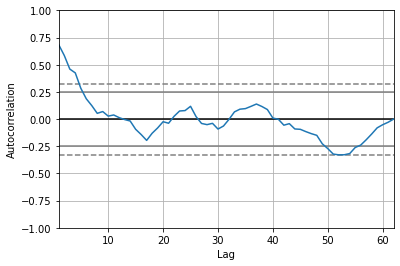

In [112]:
import matplotlib.pyplot as plt

s = training_grouped['Location']

# Creating Autocorrelation plot
x = pd.plotting.autocorrelation_plot(s)
 
# plotting the Curve
x.plot()
 
# Display
plt.show()

<AxesSubplot: xlabel='Date'>

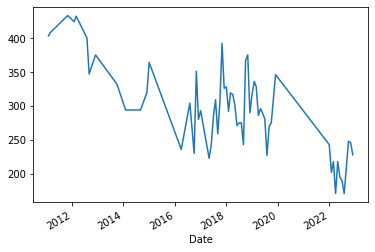

In [113]:
# Growth of burglaries over the years
s.plot()

p-value: 0.1109480543770518


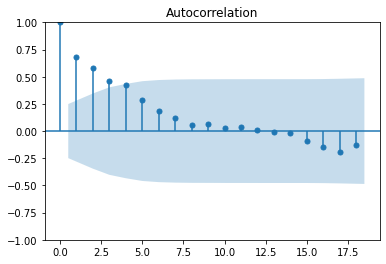

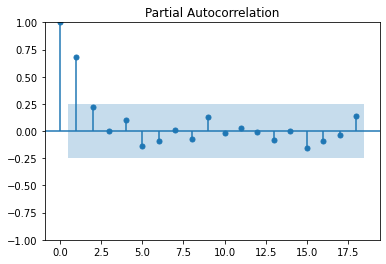

In [114]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# ADF test to see stationarity
adf_test = adfuller(training_grouped[['Location']])
# When p <= 0.05, then data is stationary
print(f'p-value: {adf_test[1]}')
# Compute autocorrelation
acf = plot_acf(training_grouped[['Location']])

# Compute partial autocorrelation function
pacf = plot_pacf(training_grouped[['Location']])

# any line inside the blue area shouldn't be considered.


In [115]:
df_train_diff = training_grouped.diff().dropna()
df_train_diff.head()

,Crime ID,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Year,Month
Date,,,,,,,,,,,,
2011-03-01,0.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,5.0,5.0
2011-11-01,0.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,0.0,25.0,25.0
2012-02-01,424.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,424.0,-9.0,-9.0
2012-03-01,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
2012-08-01,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0


p-value: 1.6513156315275028e-09


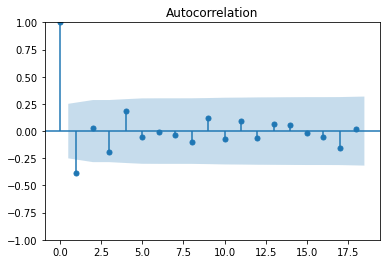

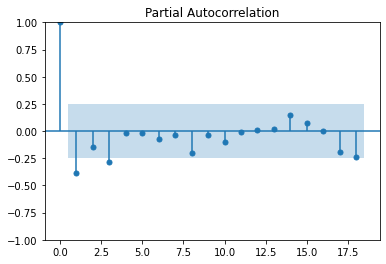

In [116]:
# ADF test to see stationarity
adf_test_new = adfuller(df_train_diff[['Location']])
# When p <= 0.05, then data is stationary
print(f'p-value: {adf_test_new[1]}')
# Compute autocorrelation
acf = plot_acf(df_train_diff[['Location']])

# Compute partial autocorrelation function
pacf = plot_pacf(df_train_diff[['Location']])

In [117]:
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(df_train_diff['Location'], order=(3,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Location   No. Observations:                   61
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -322.542
Date:                Wed, 31 May 2023   AIC                            653.084
Time:                        12:11:17   BIC                            661.461
Sample:                             0   HQIC                           656.361
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0080      0.146     -6.900      0.000      -1.294      -0.722
ar.L2         -0.7210      0.156     -4.608      0.000      -1.028      -0.414
ar.L3         -0.4465      0.133     -3.357      0.0

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



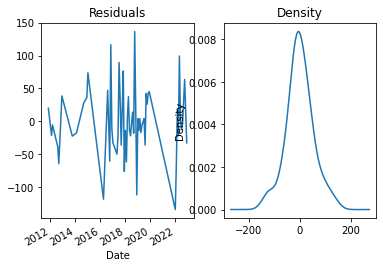

In [118]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

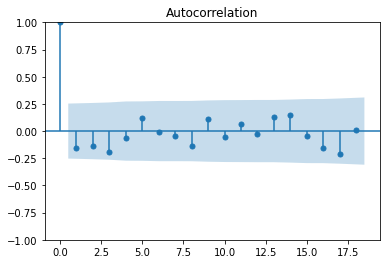

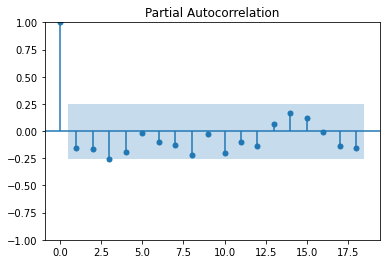

In [119]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

In [120]:
pred_start_date=validation_grouped.index[0]
pred_end_date=validation_grouped.index[-1]
print(pred_start_date, pred_end_date)

2022-01-01 00:00:00 2022-12-01 00:00:00


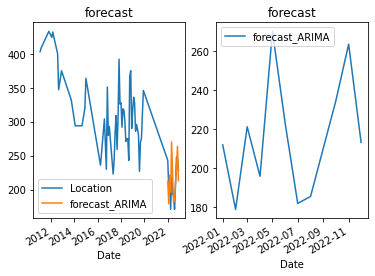

<Figure size 720x720 with 0 Axes>

In [121]:
forecast_test = model_fit.predict(start=pred_start_date, end=pred_end_date)
validation_grouped['forecast_ARIMA'] = validation_grouped['Location'] - forecast_test

fig1, ax1 = plt.subplots(1,2)
training_grouped[['Location']].plot(title='Original', ax=ax1[0])
validation_grouped[['forecast_ARIMA']].plot(title='forecast', ax=ax1[0])
validation_grouped[['forecast_ARIMA']].plot(title='forecast', ax=ax1[1])
plt.figure(figsize=(10,10))
plt.show()

<AxesSubplot: xlabel='Date'>

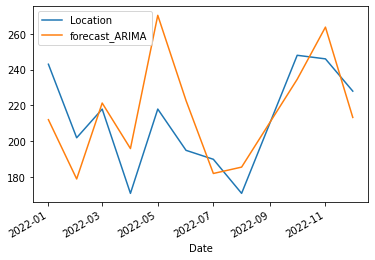

In [123]:
validation_grouped[['Location','forecast_ARIMA']].plot()

In [124]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

train, test = training_grouped['Location'], validation_grouped['Location']
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(3,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MSE: %.3f' % mse)

predicted=216.358050, expected=243.000000
predicted=240.945517, expected=202.000000
predicted=221.896053, expected=218.000000
predicted=216.646590, expected=171.000000
predicted=199.247348, expected=218.000000
predicted=202.632095, expected=195.000000
predicted=207.054044, expected=190.000000
predicted=185.944624, expected=171.000000
predicted=186.888001, expected=248.000000
predicted=216.903485, expected=246.000000
predicted=233.626528, expected=228.000000
Test RMSE: 29.943
Test MAE: 24.486
Test MSE: 896.579


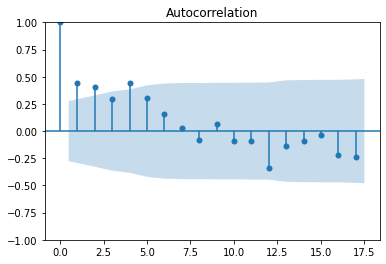

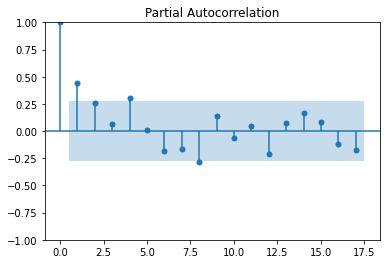

In [125]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

training_grouped['12 Difference']=training_grouped['Location']-training_grouped['Location'].shift(12)

acf12 = plot_acf(training_grouped["12 Difference"].dropna())
pacf12 = plot_pacf(training_grouped["12 Difference"].dropna())

In [126]:
model_SARIMA=SARIMAX(training_grouped['Location'],order=(2,0,4),seasonal_order=(0,1,0,12))
model_SARIMA_fit=model_SARIMA.fit()
pred_Sarima=model_SARIMA_fit.predict(start=pred_start_date,end=pred_end_date)
validation_grouped['forecast_SARIMAX'] = validation_grouped['Location'] - pred_Sarima

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<AxesSubplot: ylabel='Density'>

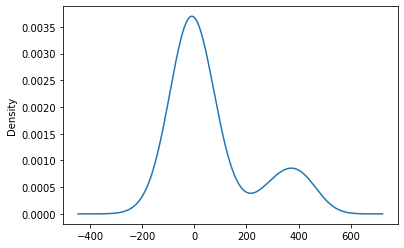

In [127]:
model_SARIMA_fit.resid.plot(kind='kde')

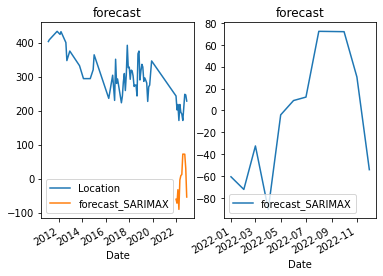

<Figure size 720x720 with 0 Axes>

In [128]:
fig12, ax12 = plt.subplots(1,2)
training_grouped[['Location']].plot(title='Original', ax=ax12[0])
validation_grouped[['forecast_SARIMAX']].plot(title='forecast', ax=ax12[0])
validation_grouped[['forecast_SARIMAX']].plot(title='forecast', ax=ax12[1])
plt.figure(figsize=(10,10))
plt.show()

<AxesSubplot: xlabel='Date'>

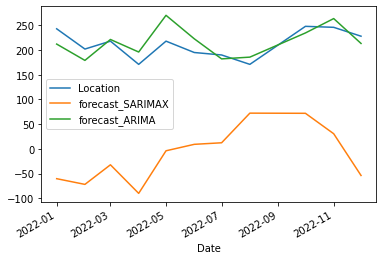

In [129]:
validation_grouped[['Location','forecast_SARIMAX', 'forecast_ARIMA']].plot()

In [130]:
train, test = training_grouped['Location'], validation_grouped['Location']
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = SARIMAX(history, order=(2,0,4),seasonal_order=(0,1,0,12))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MSE: %.3f' % mse)

predicted=358.965951, expected=243.000000
predicted=239.608072, expected=202.000000
predicted=192.446803, expected=218.000000
predicted=204.067830, expected=171.000000
predicted=112.948869, expected=218.000000
predicted=181.815059, expected=195.000000
predicted=176.431837, expected=190.000000
predicted=158.235777, expected=171.000000
predicted=176.112130, expected=248.000000
predicted=259.542167, expected=246.000000
predicted=274.003720, expected=228.000000
Test RMSE: 56.916
Test MAE: 44.382
Test MSE: 3239.374


In [131]:
burglary_data_grouped = burglary_data.groupby(['Year', 'Month']).count()
burglary_data_grouped.reset_index(inplace=True)
fig_mult = px.line(burglary_data_grouped, x='Month', y='Location', color='Year',
                   title="Seasonal Plot: Burglary Cases Growth")
fig_mult.update_yaxes(title="Number of Cases")
fig_mult.update_traces(mode="markers+lines", hovertemplate=None)
fig_mult.update_layout(hovermode="x unified")

fig_mult.show()

In [132]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_train_diff[['Location']], stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [133]:
auto_arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   61
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -316.992
Date:                Wed, 31 May 2023   AIC                            637.985
Time:                        12:17:08   BIC                            642.207
Sample:                             0   HQIC                           639.639
                                 - 61                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5125      0.113     -4.530      0.000      -0.734      -0.291
sigma2      1901.1469    351.270      5.412      0.000    1212.670    2589.624
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.48
Prob(Q):                              0.95   Prob(JB):                         0.48
Heteroskedasticity (H):               0.76   Skew:                             0.37
Prob(H) (two-sided):                  0.54   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



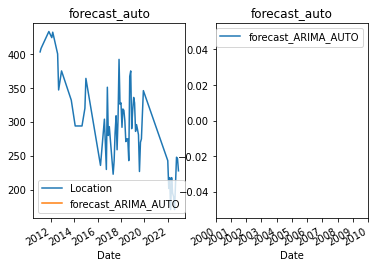

<Figure size 720x720 with 0 Axes>

In [137]:
forecast_test_auto = auto_arima.predict(start=pred_start_date, end=pred_end_date)
validation_grouped['forecast_ARIMA_AUTO'] = validation_grouped['Location'] - forecast_test_auto

fig2, ax2 = plt.subplots(1,2)
training_grouped[['Location']].plot(title='Original', ax=ax2[0])
validation_grouped[['forecast_ARIMA_AUTO']].plot(title='forecast_auto', ax=ax2[0])
validation_grouped[['forecast_ARIMA_AUTO']].plot(title='forecast_auto', ax=ax2[1])
plt.figure(figsize=(10,10))
plt.show()

<AxesSubplot: xlabel='Date'>

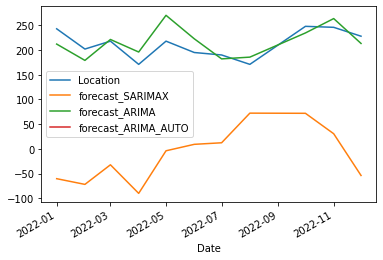

In [138]:
validation_grouped[['Location','forecast_SARIMAX', 'forecast_ARIMA', 'forecast_ARIMA_AUTO']].plot()

In [139]:
xls = pd.ExcelFile(r'.\\Datasets\\Police Workforce\\open-data-table-police-workforce-270722.ods')

# Now you can list all sheets in the file
xls.sheet_names

pwf = pd.read_excel(r'.\\Datasets\\Police Workforce\\open-data-table-police-workforce-270722.ods', sheet_name='Data')
pwf.head()


,As at 31 March...,Geo code,Force Name,Region,Sex,Rank description,Worker type,Total (headcount),Total (FTE)
0,2007,E23000036,Avon & Somerset,South West,Female,Chief Inspector,Police Officer,7,6.60
1,2007,E23000036,Avon & Somerset,South West,Female,Chief Officer,Police Officer,1,1.00
2,2007,E23000036,Avon & Somerset,South West,Female,Chief Superintendent,Police Officer,4,4.00
3,2007,E23000036,Avon & Somerset,South West,Female,Community Support Officer,Police Community Support Officer,170,164.99
4,2007,E23000036,Avon & Somerset,South West,Female,Constable,Police Officer,722,672.76


In [140]:
pwf_data_all_years = pwf.loc[(pwf['Force Name']=='Metropolitan Police') & (pwf['Total (headcount)'] != 0) & (pwf['As at 31 March...'] >= 2010)]
pwf_data_all_years = pwf_data_all_years.rename(columns={'As at 31 March...':'Year'})
pwf_data_all_years = pwf_data_all_years.fillna(0)
pwf_data_all_years['Total (FTE)'] = pwf_data_all_years['Total (FTE)'].astype(int)
pwf_data_all_years.head(100)

,Year,Geo code,Force Name,Region,Sex,Rank description,Worker type,Total (headcount),Total (FTE)
4710,2010,E23000001,Metropolitan Police,London,Female,Chief Inspector,Police Officer,55,54
4711,2010,E23000001,Metropolitan Police,London,Female,Chief Officer,Police Officer,6,6
4712,2010,E23000001,Metropolitan Police,London,Female,Chief Superintendent,Police Officer,7,7
4713,2010,E23000001,Metropolitan Police,London,Female,Community Support Officer,Police Community Support Officer,1658,1613
4714,2010,E23000001,Metropolitan Police,London,Female,Constable,Police Officer,6873,6514
...,...,...,...,...,...,...,...,...,...
10001,2014,E23000001,Metropolitan Police,London,Female,Police Staff,Police Staff,6978,6435
10002,2014,E23000001,Metropolitan Police,London,Female,Sergeant,Police Officer,868,811
10003,2014,E23000001,Metropolitan Police,London,Female,Special Constable,Special Constable,1477,0
10004,2014,E23000001,Metropolitan Police,London,Female,Superintendent,Police Officer,15,15


In [141]:
total = []
for y in pwf_data_all_years['Year'].unique():
    df_temp = pwf_data_all_years[pwf_data_all_years['Year']==y]
    total.append([y, df_temp['Total (FTE)'].sum()])

# Create the pandas DataFrame
dfwf = pd.DataFrame(total, columns=['Year', 'Police Workforce'])
  
# print dataframe.
dfwf

,Year,Police Workforce
0,2010,52509
1,2011,50572
2,2012,48179
3,2013,46121
4,2014,45010
5,2015,45564
6,2016,43909
7,2017,41868
8,2018,40321
9,2019,40791


In [142]:
# burglary_data_grouped = burglary_data.groupby(['Year', 'Month']).count()
burglary_data_grouped['Police Workforce'] = dfwf['Police Workforce']
burglary_data_grouped.head()
# print(len(burglary_data_grouped) == len(dfwf))

,Year,Month,Crime ID,Date,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Police Workforce
0,2011,2,0,403,403,403,403,403,403,403,403,403,0,52509.0
1,2011,3,0,408,408,408,408,408,408,408,408,408,0,50572.0
2,2011,11,0,433,433,433,433,433,433,433,433,433,0,48179.0
3,2012,2,424,424,424,424,424,424,424,424,424,424,424,46121.0
4,2012,3,432,432,432,432,432,432,432,432,432,432,432,45010.0


In [144]:
import xlwings as xw

workbook = xw.Book(r'.\\Datasets\\Population\\land-area-population-density-london.xlsx')
ward_sheet = workbook.sheets['Ward']
years = [x for x in range(2010, 2023)]
results = []
for year in years:
    ward_sheet.range('E1').value = year
    ward_sheet.api.Range("A2:K628").AutoFilter(Field:=3, Criteria1:="Barnet")
    results.append(
        {
            'Codes': ward_sheet.range('A21:A41').value,
            'Ward': ward_sheet.range('B21:B41').value,
            'Borough': ward_sheet.range('C21:C41').value,
            'Population': ward_sheet.range('D21:D41').value,
            'Year': [year]*21,
            'Hectares': ward_sheet.range('E21:E41').value,
            'Square Kilometres': ward_sheet.range('F21:F41').value,
            'Population per hectare': ward_sheet.range('G21:G41').value,	
            'Population per square kilometre': ward_sheet.range('H21:H41').value,
            'Census population (2011)': ward_sheet.range('J21:J41').value,	
            'Population per hectare': ward_sheet.range('K21:K41').value,
        }
    )

concat_pd = []
for i in range(len(results)):
    temp_df = pd.DataFrame(results[i])
    concat_pd.append(temp_df)
population_ward_df = pd.concat(concat_pd, ignore_index=True)
population_ward_df.head(-1)

,Codes,Ward,Borough,Population,Year,Hectares,Square Kilometres,Population per hectare,Population per square kilometre,Census population (2011)
0,E05000043,Brunswick Park,Barnet,None,2010,317.4,3.174,51.650914,None,16394.0
1,E05000044,Burnt Oak,Barnet,None,2010,206.4,2.064,88.260659,None,18217.0
2,E05000045,Childs Hill,Barnet,None,2010,308.9,3.089,64.904500,None,20049.0
3,E05000046,Colindale,Barnet,None,2010,264.2,2.642,64.716124,None,17098.0
4,E05000047,Coppetts,Barnet,None,2010,272.0,2.720,63.419118,None,17250.0
...,...,...,...,...,...,...,...,...,...,...
267,E05000058,Oakleigh,Barnet,17029.0,2022,331.7,3.317,47.666566,5133.855894,15811.0
268,E05000059,Totteridge,Barnet,17730.0,2022,876.8,8.768,17.289005,2022.125912,15159.0
269,E05000060,Underhill,Barnet,16592.0,2022,455.2,4.552,34.962654,3644.991213,15915.0
270,E05000061,West Finchley,Barnet,17794.0,2022,216.1,2.161,76.506247,8234.150856,16533.0


In [145]:
population_ward_df.loc[population_ward_df['Ward']=="Edgware"]

,Codes,Ward,Borough,Population,Year,Hectares,Square Kilometres,Population per hectare,Population per square kilometre,Census population (2011)
7,E05000050,Edgware,Barnet,None,2010,556.0,5.56,30.086331,None,16728.0
28,E05000050,Edgware,Barnet,16787.0,2011,556.0,5.56,30.086331,3019.244604,16728.0
49,E05000050,Edgware,Barnet,17299.0,2012,556.0,5.56,30.086331,3111.330935,16728.0
70,E05000050,Edgware,Barnet,17627.0,2013,556.0,5.56,30.086331,3170.323741,16728.0
91,E05000050,Edgware,Barnet,18175.0,2014,556.0,5.56,30.086331,3268.884892,16728.0
112,E05000050,Edgware,Barnet,18633.0,2015,556.0,5.56,30.086331,3351.258993,16728.0
133,E05000050,Edgware,Barnet,19706.0,2016,556.0,5.56,30.086331,3544.244604,16728.0
154,E05000050,Edgware,Barnet,20021.0,2017,556.0,5.56,30.086331,3600.899281,16728.0
175,E05000050,Edgware,Barnet,20359.0,2018,556.0,5.56,30.086331,3661.690647,16728.0
196,E05000050,Edgware,Barnet,20656.0,2019,556.0,5.56,30.086331,3715.107914,16728.0


In [146]:
crime_ward_df = pd.read_csv(r'.\\Datasets\\Crime History\\Ward Level Crime.csv')
crime_ward_df_grouped = crime_ward_df.groupby(['Ward', 'Year', 'Month' ], as_index=False)['Crime type'].count()
crime_ward_df_grouped.head()	

,Ward,Year,Month,Crime type
0,Barnet Vale,2011,2,29
1,Barnet Vale,2011,3,27
2,Barnet Vale,2011,11,28
3,Barnet Vale,2012,2,24
4,Barnet Vale,2012,3,32


In [147]:
fig_ward = px.line(crime_ward_df.groupby(['Ward', 'Year']).size().reset_index(name='Burglary Rate'), x='Year', y='Burglary Rate', color='Ward',
                   title="Seasonal Plot: Ward Burglary Cases Growth")
fig_ward.update_yaxes(title="Number of Cases")
fig_ward.update_traces(mode="markers+lines", hovertemplate=None)
fig_ward.update_layout(hovermode="x unified")

fig_ward.show()

In [148]:
df2 = pd.merge(crime_ward_df.groupby(['Date', 'Ward', 'Year', 'Reported by', 'Falls within', 'Crime type']).size().reset_index(name='Burglary Rate'), population_ward_df, how='inner', on=['Year', 'Ward'])

df3 = pd.merge(df2, dfwf, how='inner', on='Year')
df3.head()

,Date,Ward,Year,Reported by,Falls within,Crime type,Burglary Rate,Codes,Borough,Population,Hectares,Square Kilometres,Population per hectare,Population per square kilometre,Census population (2011),Police Workforce
0,2011-02-01,Brunswick Park,2011,Metropolitan Police Service,Metropolitan Police Service,Burglary,36,E05000043,Barnet,16454.0,317.4,3.174,51.650914,5183.994959,16394.0,50572
1,2011-03-01,Brunswick Park,2011,Metropolitan Police Service,Metropolitan Police Service,Burglary,25,E05000043,Barnet,16454.0,317.4,3.174,51.650914,5183.994959,16394.0,50572
2,2011-11-01,Brunswick Park,2011,Metropolitan Police Service,Metropolitan Police Service,Burglary,43,E05000043,Barnet,16454.0,317.4,3.174,51.650914,5183.994959,16394.0,50572
3,2011-02-01,Burnt Oak,2011,Metropolitan Police Service,Metropolitan Police Service,Burglary,15,E05000044,Barnet,18279.0,206.4,2.064,88.260659,8856.104651,18217.0,50572
4,2011-03-01,Burnt Oak,2011,Metropolitan Police Service,Metropolitan Police Service,Burglary,13,E05000044,Barnet,18279.0,206.4,2.064,88.260659,8856.104651,18217.0,50572


In [149]:
income_ward_df = pd.read_csv(r'.\\Datasets\\Population\\modelled-household-income-estimates-wards.csv', encoding='latin1')
income_ward_df = income_ward_df.loc[(income_ward_df['Borough']=='Barnet')]
tomelt = [income_ward_df.columns[i] for i in range(0, 4)]
income_ward_df = pd.melt(income_ward_df, id_vars=tomelt, 
        var_name="Date", 
        value_name="Mean Income (£)")
temp_df = income_ward_df[income_ward_df['Date'].str.contains("Median")]
temp_df = temp_df.rename(columns={'Mean Income (£)':'Median Income (£)'})
income_ward_df = income_ward_df[income_ward_df['Date'].str.contains("Mean")]
income_ward_df = pd.concat([income_ward_df.reset_index(drop=True), temp_df[['Median Income (£)']].reset_index(drop=True)], axis=1)
income_ward_df[income_ward_df.columns[5:]] = income_ward_df[income_ward_df.columns[5:]].replace('[\£,]', '', regex=True).astype(float)
income_ward_df['Year'] = income_ward_df.Date.str[5:9]
income_ward_df = income_ward_df.drop(['Date'], axis=1)
income_ward_df['Year']  = income_ward_df['Year'].astype('Int64')
income_ward_df = income_ward_df.rename({'Code' : 'Codes', 'Ward name' : 'Ward'}, axis=1)
income_ward_df

,Codes,Ward,LAD code,Borough,Mean Income (£),Median Income (£),Year
0,E05000043,Brunswick Park,E09000003,Barnet,37840.0,28580.0,2001
1,E05000044,Burnt Oak,E09000003,Barnet,26640.0,20460.0,2001
2,E05000045,Childs Hill,E09000003,Barnet,38500.0,29020.0,2001
3,E05000046,Colindale,E09000003,Barnet,27820.0,21380.0,2001
4,E05000047,Coppetts,E09000003,Barnet,36930.0,27960.0,2001
...,...,...,...,...,...,...,...
247,E05000059,Totteridge,E09000003,Barnet,63320.0,46150.0,2012
248,E05000060,Underhill,E09000003,Barnet,49390.0,37040.0,2012
249,E05000061,West Finchley,E09000003,Barnet,56850.0,42050.0,2012
250,E05000062,West Hendon,E09000003,Barnet,46620.0,35090.0,2012


In [150]:
df4 = df3.merge(income_ward_df[income_ward_df['Year']>=2011], how='left', left_on=['Year', 'Ward', 'Codes', 'Borough'], right_on=['Year', 'Ward', 'Codes', 'Borough'])
wardinter = {}
wardinter1 = {}
for ward in df4['Ward'].unique():
    wardinter[ward] = df4[df4['Ward']==ward]['Mean Income (£)'].interpolate('spline', order=1)
    wardinter1[ward] = df4[df4['Ward']==ward]['Median Income (£)'].interpolate('spline', order=1)
    df4.loc[df4['Ward']==ward, 'Mean Income (£)'] = wardinter[ward]
    df4.loc[df4['Ward']==ward, 'Median Income (£)'] = wardinter1[ward]
df4.head(-1)


,Date,Ward,Year,Reported by,Falls within,Crime type,Burglary Rate,Codes,Borough,Population,Hectares,Square Kilometres,Population per hectare,Population per square kilometre,Census population (2011),Police Workforce,LAD code,Mean Income (£),Median Income (£)
0,2011-02-01,Brunswick Park,2011,Metropolitan Police Service,Metropolitan Police Service,Burglary,36,E05000043,Barnet,16454.0,317.4,3.174,51.650914,5183.994959,16394.0,50572,E09000003,52420.000000,39130.000000
1,2011-03-01,Brunswick Park,2011,Metropolitan Police Service,Metropolitan Police Service,Burglary,25,E05000043,Barnet,16454.0,317.4,3.174,51.650914,5183.994959,16394.0,50572,E09000003,52420.000000,39130.000000
2,2011-11-01,Brunswick Park,2011,Metropolitan Police Service,Metropolitan Police Service,Burglary,43,E05000043,Barnet,16454.0,317.4,3.174,51.650914,5183.994959,16394.0,50572,E09000003,52420.000000,39130.000000
3,2011-02-01,Burnt Oak,2011,Metropolitan Police Service,Metropolitan Police Service,Burglary,15,E05000044,Barnet,18279.0,206.4,2.064,88.260659,8856.104651,18217.0,50572,E09000003,38100.000000,28800.000000
4,2011-03-01,Burnt Oak,2011,Metropolitan Police Service,Metropolitan Police Service,Burglary,13,E05000044,Barnet,18279.0,206.4,2.064,88.260659,8856.104651,18217.0,50572,E09000003,38100.000000,28800.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,2022-06-01,Woodhouse,2022,Metropolitan Police Service,Metropolitan Police Service,Burglary,6,E05000063,Barnet,18844.0,261.2,2.612,67.285605,7214.3951,17575.0,45138,NaN,50806.270728,38019.475042
920,2022-07-01,Woodhouse,2022,Metropolitan Police Service,Metropolitan Police Service,Burglary,3,E05000063,Barnet,18844.0,261.2,2.612,67.285605,7214.3951,17575.0,45138,NaN,50805.903734,38019.224377
921,2022-08-01,Woodhouse,2022,Metropolitan Police Service,Metropolitan Police Service,Burglary,1,E05000063,Barnet,18844.0,261.2,2.612,67.285605,7214.3951,17575.0,45138,NaN,50805.536740,38018.973712
922,2022-10-01,Woodhouse,2022,Metropolitan Police Service,Metropolitan Police Service,Burglary,4,E05000063,Barnet,18844.0,261.2,2.612,67.285605,7214.3951,17575.0,45138,NaN,50805.169746,38018.723047


In [151]:
fig_income = px.line(df4, x='Year', y='Mean Income (£)', color='Ward',
                   title="Seasonal Plot: Ward Burglary Cases Growth")
fig_income.update_yaxes(title="Mean Income (£)")
fig_income.update_traces(mode="markers+lines", hovertemplate=None)
fig_income.update_layout(hovermode="x unified")

fig_income.show()

In [152]:
Real_df = df4.loc[(df4['Year'] == 2011) | (df4['Year'] == 2012)]
fig_pcp = go.Figure(data=
    go.Parcoords(
        line = dict(colorscale = 'Electric',
                   showscale = True),
        dimensions = list([
            dict(
                 label = "Year", values = Real_df['Year']),
            dict(range = [0,40000],
                 label = 'Population per Ward', values = Real_df['Population']),
            dict(range = [0,80000],
                 label = 'Police Workforce', values = Real_df['Police Workforce']),
            dict(range = [0,80000],
                 visible = True,
                 label = 'Mean Income', values = Real_df['Mean Income (£)']),
            dict(range = [0,200],
                 ticktext = ['0','50','100','150','200'],
                 label = 'Burglary Rate per Day', values = Real_df['Burglary Rate']),
            dict(range = [0,80000],
                 label = 'Median Income', values = Real_df['Median Income (£)'])])
    )
)
fig_pcp.show()

In [153]:

filtered_df = pd.read_csv(r'.\\Datasets\\Population\\filtered_df.csv')
filtered_df = filtered_df.rename(columns={'Ward new' : 'Ward', 'Month' : 'Date'})
filtered_df_new = pd.merge(filtered_df.groupby(['Date', 'Ward', 'Year', 'Reported by', 'Falls within', 'Crime type', 'Month name', 'Month num']).size().reset_index(name='Burglary Rate'), population_ward_df, how='inner', on=['Year', 'Ward'])
filtered_df_new = pd.merge(filtered_df_new, dfwf, how='inner', on='Year')
filtered_df_new = filtered_df_new.merge(income_ward_df[income_ward_df['Year']>=2010], how='left', left_on=['Year', 'Ward', 'Codes', 'Borough'], right_on=['Year', 'Ward', 'Codes', 'Borough'])

me = {}
med = {}
for ward in filtered_df_new['Ward'].unique():
    me[ward] = filtered_df_new[filtered_df_new['Ward']==ward]['Mean Income (£)'].interpolate('spline', order=1)
    med[ward] = filtered_df_new[filtered_df_new['Ward']==ward]['Median Income (£)'].interpolate('spline', order=1)
    filtered_df_new.loc[filtered_df_new['Ward']==ward, 'Mean Income (£)'] = me[ward]
    filtered_df_new.loc[filtered_df_new['Ward']==ward, 'Median Income (£)'] = med[ward]

# filtered_df_new.to_csv(r'.\\Datasets\\Population\\filtered_df_utility_cols.csv', index=False)